<a href="https://colab.research.google.com/github/israelklink/Financas_Descentralizadas_Python/blob/main/Simulacao_MakerDAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

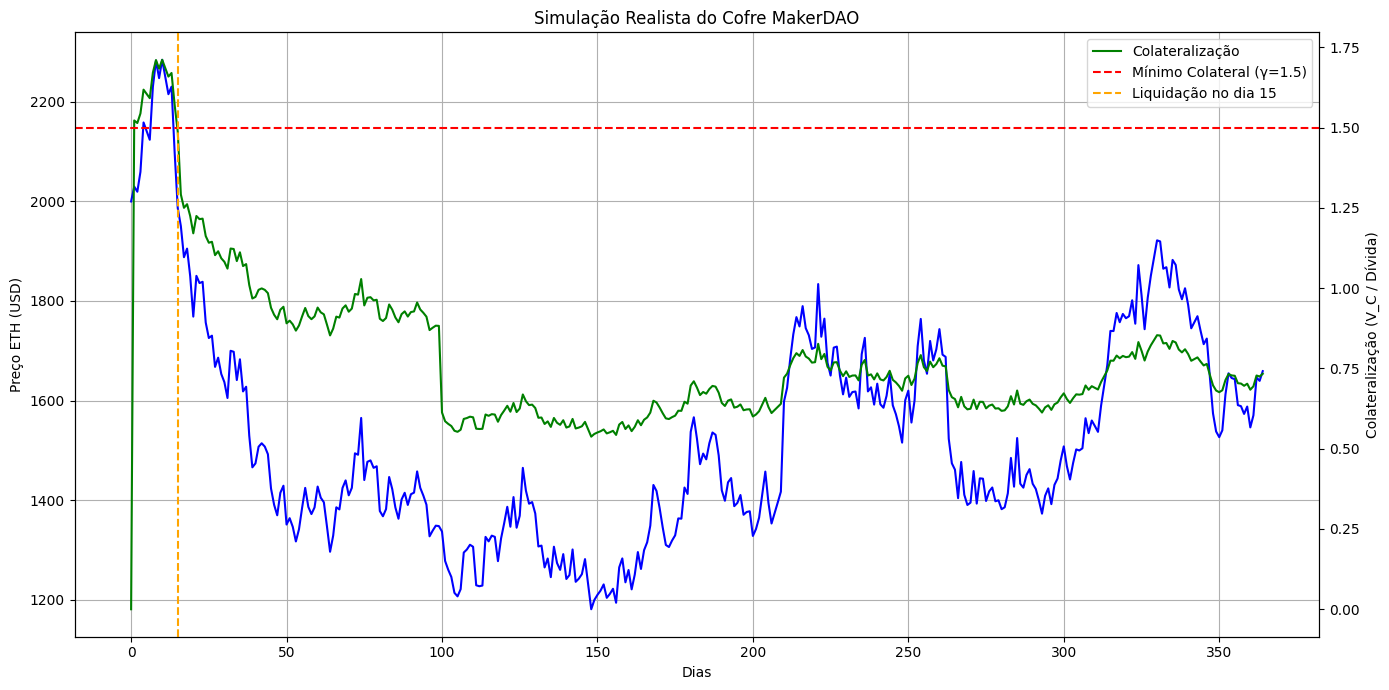



=== Resultado da Simulação do MakerDAO ===
Dívida inicial emitida (DAI):       $133,333.33
Preço final do ETH (USD):           $1,659.07
Valor final do colateral (USD):     $116,134.70
Dívida final (DAI):                 $158,369.28
Colateralização final:               73.33%
Dia da liquidação:                   15
----------------------------------------
DÉFICIT no protocolo:               $42,234.58
Quantidade de MKR a ser emitida:   21.1173 MKR


In [32]:
def simular_makerdao_realista(
    q_C=1200,               # Quantidade inicial de ETH
    P_C0=2000,             # Preço inicial do ETH
    mu=-0.01,               # Drift anual do preço (queda média de 10%)
    sigma=0.03,             # Volatilidade anual do ETH (~60%)
    gamma=1,             # Colateralização mínima (150%)
    r_s=0.05,              # Stability fee anual (5%)
    dias=365,              # Período de simulação (1 ano)
    lambda_liquid=0.13,    # Penalidade de liquidação (13%)
    add_eth_days=None,     # Lista de tuplas (dia, quantidade) para adicionar ETH
    repay_dai_days=None    # Lista de tuplas (dia, quantidade) para pagar dívida
):
    dt = 1/365
    np.random.seed(42)  # Para resultados reproduzíveis

    D0 = (q_C * P_C0) / gamma   # Dívida inicial em DAI
    q_eth = q_C
    debt = D0

    P_C = np.zeros(dias)
    P_C[0] = P_C0

    colat_ratio = np.zeros(dias)
    debt_array = np.zeros(dias)
    collateral_value = np.zeros(dias)

    liquidated = False
    liquid_day = None

    add_eth_days = add_eth_days or []
    repay_dai_days = repay_dai_days or []
    add_eth_dict = dict(add_eth_days)
    repay_dai_dict = dict(repay_dai_days)

    for t in range(1, dias):
        dW = np.random.normal(0, np.sqrt(dt))
        P_C[t] = P_C[t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma*dW)

        debt = debt * (1 + r_s * dt)

        if t in add_eth_dict:
            q_eth += add_eth_dict[t]

        if t in repay_dai_dict:
            payment = repay_dai_dict[t]
            debt = max(debt - payment, 0)

        V_C = q_eth * P_C[t]
        cr = V_C / debt if debt > 0 else np.inf

        collateral_value[t] = V_C
        debt_array[t] = debt
        colat_ratio[t] = cr

        if (cr < gamma) and (not liquidated):
            liquidated = True
            liquid_day = t
            debt = debt * (1 + lambda_liquid)
            debt_array[t] = debt

    plt.figure(figsize=(14,7))
    plt.plot(range(dias), P_C, label='Preço ETH (USD)', color='blue')
    plt.ylabel('Preço ETH (USD)')
    plt.xlabel('Dias')
    plt.title('Simulação Realista do Cofre MakerDAO')
    plt.grid(True)

    plt.twinx()
    plt.plot(range(dias), colat_ratio, label='Colateralização', color='green')
    plt.axhline(gamma, color='red', linestyle='--', label=f'Mínimo Colateral (γ={gamma})')
    if liquid_day:
        plt.axvline(liquid_day, color='orange', linestyle='--', label=f'Liquidação no dia {liquid_day}')
    plt.ylabel('Colateralização (V_C / Dívida)')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    return {
        "DAI_emitido_inicial": round(float(D0),2),
        "Preco_final_ETH": round(float(P_C[-1]),2),
        "Valor_final_colateral": round(float(collateral_value[-1]),2),
        "Divida_final": round(float(debt_array[-1]),2),
        "Colateralizacao_final": round(float(colat_ratio[-1]),4),
        "Dia_liquidacao": liquid_day if liquid_day else "Não ocorreu"
    }


def calcular_emissao_mkr(dai_total, valor_colateral, preco_mkr):
    """
    Calcula o número de MKR a ser emitido para cobrir o déficit no protocolo MakerDAO.

    Parâmetros:
    - dai_total (float): Total de DAI em circulação (em USD)
    - valor_colateral (float): Valor total dos colaterais em USD
    - preco_mkr (float): Preço atual do MKR em USD

    Retorno:
    - deficit (float): Valor em USD que falta para cobrir o DAI
    - mkr_emitido (float): Quantidade de MKR que precisa ser emitida
    """
    deficit = dai_total - valor_colateral

    if deficit <= 0:
        return 0.0, 0.0  # Nenhum MKR precisa ser emitido

    mkr_emitido = deficit / preco_mkr
    return deficit, mkr_emitido


def simular_e_calcular_mkr(
    q_C=100, P_C0=2000, mu=-0.1, sigma=0.6, gamma=1.5, r_s=0.05, dias=365, lambda_liquid=0.13,
    add_eth_days=None, repay_dai_days=None, preco_mkr=2000
):
    resultado_sim = simular_makerdao_realista(
        q_C, P_C0, mu, sigma, gamma, r_s, dias, lambda_liquid, add_eth_days, repay_dai_days
    )
    dai_total = resultado_sim["Divida_final"]
    valor_colateral = resultado_sim["Valor_final_colateral"]

    deficit, mkr_emitido = calcular_emissao_mkr(dai_total, valor_colateral, preco_mkr)

    return {
        "resultado_simulacao": resultado_sim,
        "deficit": round(deficit,2),
        "mkr_emitido": round(mkr_emitido,4)
    }


# Exemplo de execução
res = simular_e_calcular_mkr(
    add_eth_days=[(100, -30)],  # Retira 30 ETH no dia 100, para forçar déficit
    repay_dai_days=[(200, 0)],  # Sem pagamento de dívida
    preco_mkr=2000
)

print("\n")
def imprimir_resultado(res):
    sim = res["resultado_simulacao"]

    print("=== Resultado da Simulação do MakerDAO ===")
    print(f"Dívida inicial emitida (DAI):       ${sim['DAI_emitido_inicial']:,.2f}")
    print(f"Preço final do ETH (USD):           ${sim['Preco_final_ETH']:,.2f}")
    print(f"Valor final do colateral (USD):     ${sim['Valor_final_colateral']:,.2f}")
    print(f"Dívida final (DAI):                 ${sim['Divida_final']:,.2f}")
    print(f"Colateralização final:               {sim['Colateralizacao_final']*100:.2f}%")
    print(f"Dia da liquidação:                   {sim['Dia_liquidacao']}")
    print("----------------------------------------")
    print(f"DÉFICIT no protocolo:               ${res['deficit']:,.2f}")
    print(f"Quantidade de MKR a ser emitida:   {res['mkr_emitido']:,.4f} MKR")
    print("========================================")

# Usando com seu resultado
imprimir_resultado(res)